# H3-ify the CDC HHI data

In [1]:
# see claude chat https://claude.ai/chat/603b2f08-d81a-4414-9fd8-750adaa7b469

## fetch data and merge CDC Heat and Health Index Data + US Census ZCTA Map

In [2]:
# get the data

# code generated by Claude https://claude.ai/chat/9b0de591-0e95-4c91-8e9a-61f233c81716

import os
import requests
import zipfile
import pandas as pd
import geopandas as gpd

# Helper functions
def download_file(url, local_filename):
    if not os.path.exists(local_filename):
        print(f"Downloading {url}...")
        response = requests.get(url)
        response.raise_for_status()
        with open(local_filename, 'wb') as file:
            file.write(response.content)
        print(f"Saved to {local_filename}")
    else:
        print(f"{local_filename} already exists.")

def convert_excel_to_parquet(excel_file_path, parquet_file_path):
    if not os.path.exists(parquet_file_path):
        df = pd.read_excel(excel_file_path)
        df.to_parquet(parquet_file_path, index=False)
        print(f"Converted {excel_file_path} to {parquet_file_path}")
    else:
        print(f"Parquet file {parquet_file_path} already exists.")

def load_cdc_data(data_dir):
    # Load CDC Heat and Health Index Data
    boundaries_url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_zcta520_500k.zip"
    boundaries_zip = os.path.join(data_dir, "cb_2020_us_zcta520_500k.zip")
    if not os.path.exists(boundaries_zip):
        download_file(boundaries_url, boundaries_zip)
        with zipfile.ZipFile(boundaries_zip, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
    boundaries_file = os.path.join(data_dir, "cb_2020_us_zcta520_500k.shp")
    zcta_boundaries = gpd.read_file(boundaries_file).to_crs(epsg=4326)
    
    excel_url = "https://gis.cdc.gov/HHI/Documents/HHI_Data.zip"
    excel_zip = os.path.join(data_dir, "HHI_Data.zip")
    excel_file = os.path.join(data_dir, "HHI Data 2024 United States.xlsx")
    parquet_file = os.path.join(data_dir, "HHI Data 2024 United States.parquet")
    
    if not os.path.exists(parquet_file):
        download_file(excel_url, excel_zip)
        with zipfile.ZipFile(excel_zip, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        convert_excel_to_parquet(excel_file, parquet_file)
    hhi_data = pd.read_parquet(parquet_file)
    
    hhi_data['ZCTA'] = hhi_data['ZCTA'].astype(str)
    zcta_boundaries['ZCTA5CE20'] = zcta_boundaries['ZCTA5CE20'].astype(str)
    zcta_with_hhi = zcta_boundaries.merge(hhi_data, left_on='ZCTA5CE20', right_on='ZCTA', how='inner')
    
    return zcta_with_hhi


data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)

zcta_with_hhi = load_cdc_data(data_dir)


<Axes: >

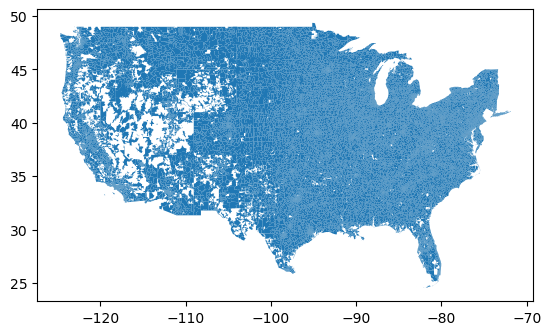

In [3]:
zcta_with_hhi.plot()

In [4]:
zcta_with_hhi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# derived from https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb

## convert ZCTA polygon to hex

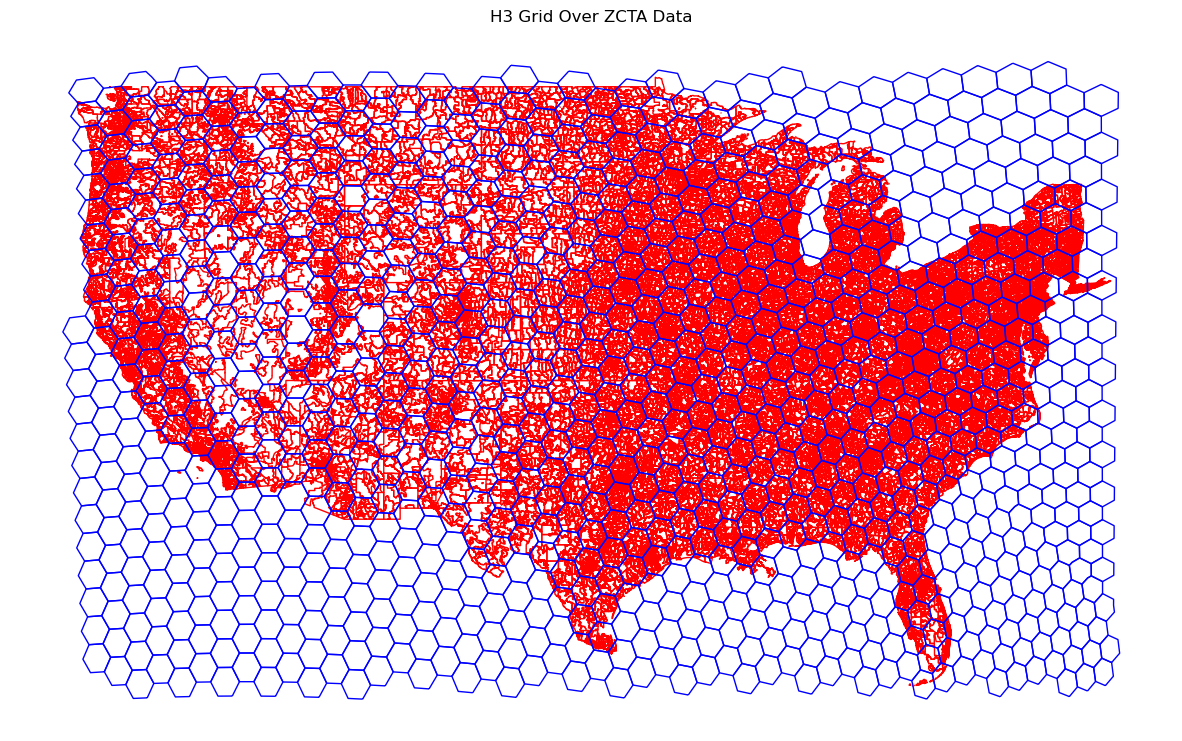

In [10]:
import h3
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Polygon

def create_h3_grid(bounds, resolution=7):
    min_lon, min_lat, max_lon, max_lat = bounds
    hexagons = h3.polyfill_geojson(
        {"type": "Polygon", "coordinates": [[[min_lon, min_lat], [max_lon, min_lat], [max_lon, max_lat], [min_lon, max_lat], [min_lon, min_lat]]]},
        resolution
    )
    
    polygons = []
    for hex_id in hexagons:
        polygon = Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
        polygons.append(polygon)
    
    return gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")

# Now apply to your actual data
zcta_bounds = zcta_with_hhi.total_bounds
zcta_h3_grid = create_h3_grid(zcta_bounds, resolution=3)

# Plot your data
fig, ax = plt.subplots(figsize=(15, 10))
zcta_with_hhi.plot(ax=ax, edgecolor='red', facecolor='none')
zcta_h3_grid.plot(ax=ax, edgecolor='blue', facecolor='none')
ax.set_title('H3 Grid Over ZCTA Data')
plt.axis('off')
plt.show()

# both layers 

Optimal H3 resolution: 15


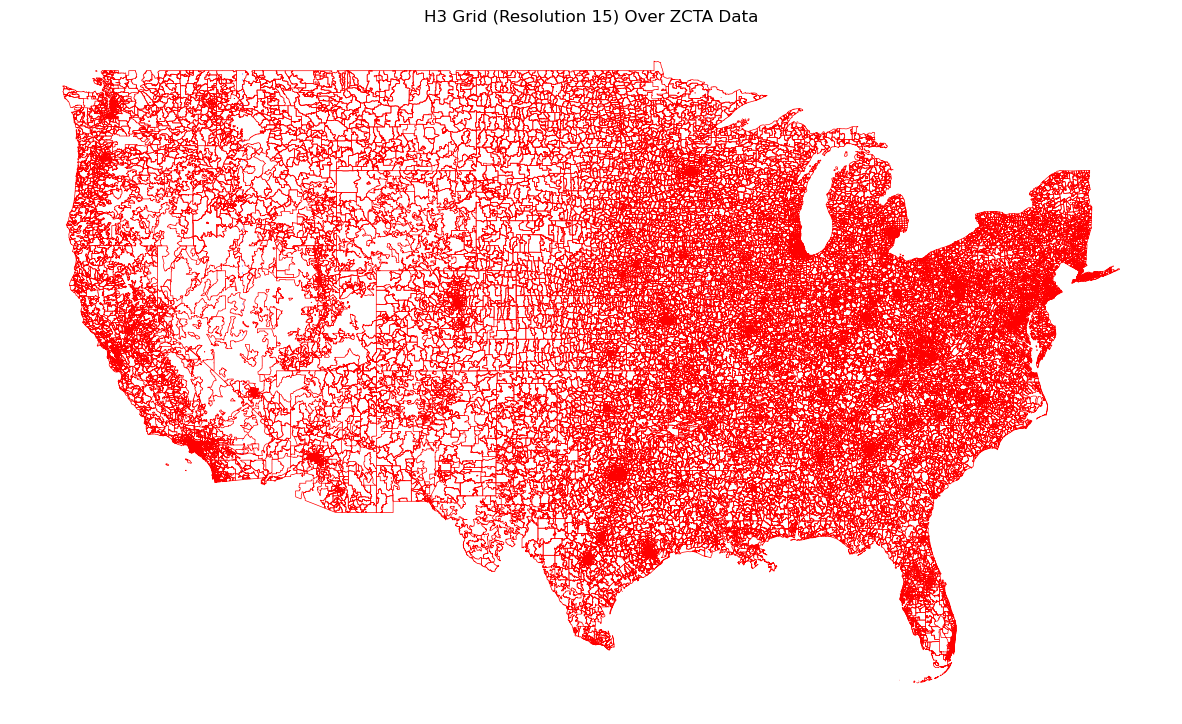

Number of ZCTAs: 29706
Number of H3 hexagons: 5405


In [21]:
import h3
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def create_h3_grid(gdf, resolution=7):
    bounds = gdf.total_bounds
    min_lon, min_lat, max_lon, max_lat = bounds
    
    lats = np.arange(min_lat, max_lat, (max_lat - min_lat) / 100)
    lons = np.arange(min_lon, max_lon, (max_lon - min_lon) / 100)
    
    hexagons = set()
    for lat in lats:
        for lon in lons:
            hexagons.add(h3.geo_to_h3(lat, lon, resolution))
    
    polygons = []
    for hex_id in hexagons:
        polygon = Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))
        polygons.append(polygon)
    
    return gpd.GeoDataFrame(geometry=polygons, crs=gdf.crs)

def find_optimal_resolution(gdf):
    area = gdf.to_crs(gdf.estimate_utm_crs()).area.mean()
    for res in range(15, 0, -1):
        hex_area = h3.hex_area(res, unit='m^2')
        if hex_area < area:
            return res
    return 0

# Ensure ZCTA data is in EPSG:4326
zcta_with_hhi = zcta_with_hhi.to_crs("EPSG:4326")

# Find optimal resolution
optimal_resolution = find_optimal_resolution(zcta_with_hhi)
print(f"Optimal H3 resolution: {optimal_resolution}")

# Create H3 grid
zcta_h3_grid = create_h3_grid(zcta_with_hhi, resolution=optimal_resolution)

# Clip H3 grid to ZCTA boundaries
zcta_h3_grid_clipped = gpd.overlay(zcta_h3_grid, zcta_with_hhi, how='intersection')

# Plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot ZCTA boundaries
zcta_with_hhi.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=0.5)

# Plot H3 hexagons
zcta_h3_grid_clipped.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.2)

ax.set_title(f'H3 Grid (Resolution {optimal_resolution}) Over ZCTA Data')
plt.axis('off')
plt.show()

# Print some statistics
print(f"Number of ZCTAs: {len(zcta_with_hhi)}")
print(f"Number of H3 hexagons: {len(zcta_h3_grid_clipped)}")

<Axes: >

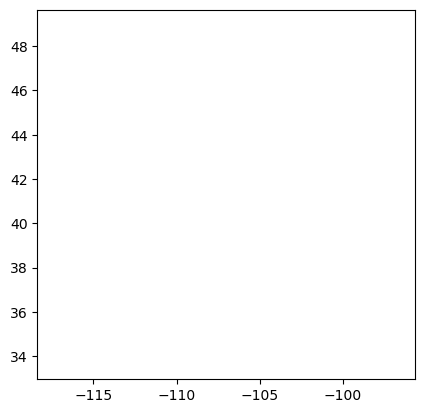

In [26]:
zcta_h3_grid_clipped.head().plot()